## Creating a Logistic Regression Model

Logistic Regression is classification algorithm commonly used in machine learning. It allows us to categorize data into discrete classes (binary categories) by learning the relationship from a given set of labeled data. A logistic regression model learns a linear relationship from the given dataset and then introduces a non-linearity in the form of the Sigmoid function, described below, to return a probability value between 0 and 1.

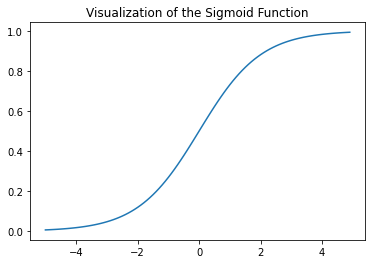

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
  
def sigmoid(z): 
    return 1 / (1 + np.exp( - z)) 
  
plt.plot(np.arange(-5, 5, 0.1), sigmoid(np.arange(-5, 5, 0.1))) 
plt.title('Visualization of the Sigmoid Function') 
  
plt.show() 

## Load the dataset

The Iris flower dataset is available on [Keras Dataset API](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html). 

The following code loads the Iris dataset.

In [2]:
from sklearn import datasets

# import iris data from sklearn datasets library
iris = datasets.load_iris()

In [3]:
import pandas as pd
import tensorflow as tf
# To use tenforflow 1.x functions, import compact v1
# import tensorflow.compat.v1 as tf
# tf.enable_eager_execution()
# # # make unable to use tensorflow v2.x functions to avoid crash
# tf.disable_v2_behavior()

# change to pandas dataframe
iris = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris = iris.astype({"target": int })

print(iris)
print(iris.shape)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target  
0         0  

## Explore the data 

Let's take a moment to understand the format of the data. Each data contains sepal length, sepal width, petal length, petal width and a corresponding species label. The label is an integer value of either 0 or 1, where 0 is a `Iris-setosa`, and 1 is a `Iris-versicolo`.

In [4]:
# Check the head of dataframe
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


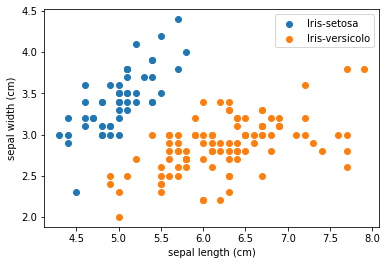

In [5]:
# Make a scatter plot with sepal length and width between two iris species in the dataframe
import matplotlib.pyplot as plt

plt.scatter(iris['sepal length (cm)'][:50], iris['sepal width (cm)'][:50], label='Iris-setosa')
plt.scatter(iris['sepal length (cm)'][51:], iris['sepal width (cm)'][51:], label='Iris-versicolo')
# plt.scatter(iris['sepal length (cm)'][101:], iris['sepal width (cm)'][101:], label='Iris-virginica')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend(loc='best')

## Processing Data

We need to process our data to split the overall dataset into a training set and a test set.

The x-value from our dataset will become the features (sepal length, sepal width, petal length, petal width) and y value as species (labels -- `Iris-setosa` or `Iris-versicolo`) from the Iris dataframe.

In [6]:
x = iris.drop(labels=['target'], axis=1).values
y = iris['target'].values

Set a seed to get reproducibility for numpy and tensorflow so for the next step, our training and test dataset are split the same way each time you run the notebook.

In [7]:
seed = 23
np.random.seed(seed)
tf.random.set_seed(seed)

Next, we split the dataset into a training set (60%, used to train our model and familiarize the model with the kind of data it will be classifying) and a test set (40%, evaluate the model and how effective it is as classifying new, unseen before data).

In [8]:
# use random choice from numpy library to set dataset randomly
train_data = np.random.choice(len(x), round(len(x) * 0.6), replace=False)
test_data = np.array(list(set(range(len(x))) - set(train_data)))

# separate the dataset into features and labels
x_train = x[train_data]
y_train = y[train_data]
x_test = x[test_data]
y_test = y[test_data]

# the number of labels
num_labels = 3 

# the number of features: sepal length & width, petal length & width
num_features = 4

# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])


Now, we normalize the feature values in the dataset. Normalization is optional for logistic regression, however, the main goal of normalizing features is to help the convergence of the technique used for optimization. 

(TODO: explain a bit more about normalization)

In [9]:
# Define the normalization function
def min_max_normalization(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)

In [10]:
# Normalized processing, must be placed after the data set segmentation, 
# otherwise the test set will be affected by the training set
x_train = min_max_normalization(x_train)
x_test = min_max_normalization(x_test)

In [11]:
# make y dataset shape to fit on model dimensions as multi-class classification
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [12]:
# print(x_test)

## Build the model

With the processed dataset, we can now start to build the model with Tensorflow and Keras. You'll notice that our model has an activation function, which defines the output range of our model. As mentioned, we will be using the Sigmoid function as our activation function to normalize our output between 0 and 1. 

There are a few other activation functions that you can try out and see how they affect the model. Learn about more activation functions through the [Keras documentation](https://keras.io/api/layers/activations/).

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import L1L2

# Set up the logistic regression model
model = Sequential()
# the number of class, Iris dataset has 3 classes
output_dim = num_labels
# input dimension = number of features your data has
input_dim = num_features

model.add(Dense(output_dim,
                input_dim = input_dim,
                activation='sigmoid'
                )) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


Before training our model, we also need to set a few parameters: learning rate, batch size, and the number of epoch interations.
* <b>Learning rate</b> is a hyper-parameter that controls how much we are adjusting the weights of our network with respect the loss gradient.
* <b>Batch size</b> defines the number of samples that will be propagated through the network.
* An <b>epoch</b> is a full iteration over our samples during model training. 

Feel free to adjust these parameters, especially the learning rate and number of epochs. How do they change the model's accuracy and loss?

In [14]:
learning_rate = 0.03
batch_size = 32
epochs_num = 10

### Loss function and optimizer

Here, we declare a loss function for our linear regression. Why does we need one?

The loss function is critical for machine & deep learning models.
The loss function for linear regression is squared loss, but the loss function for logistic regression is Log Loss, which is defined as follows:

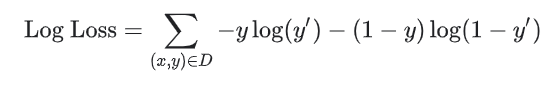

where:

* (x,y) ∈ D is the data set containing many labeled examples, which are  (x,y) pairs.
* y is the label in a labeled example. Since this is logistic regression, every value of y must either be 0 or 1.
* y' is the predicted value (somewhere between 0 and 1), given the set of features in x.


In [15]:
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Setup Callback function
# Requires: model and validation_data (X and Y values of test data)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=[0, 1])

# confusion_matrix_updates = ConfMatrixCallbackPlotter(
#                                 model = model,
#                                 scaler = scaler,
#                                 validation_data = (x_test, y_test),
#                                 original_input = x_test)

import libraries.extractioncallback as excb

extractor = excb.CallbackDataExtractor(
    model = model,
    layer = 0,
    validation_data = (x_test, y_test),
    rec_int_values = False,
    is_bin = False
)

## Train the model

We can start to train our model. We use the parameters that we set above. The `validation_split` parameter selects what fraction of our training data will be held as validation data, used to evaluate model metrics per epoch.

In [16]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs_num, validation_split=0.3, callbacks=[extractor])


Epoch 1/10
2/2 [==============================] - 1s 363ms/step - loss: 1.0547 - accuracy: 0.3196 - val_loss: 1.0380 - val_accuracy: 0.3929
Epoch 2/10
2/2 [==============================] - 0s 60ms/step - loss: 1.0531 - accuracy: 0.3300 - val_loss: 1.0345 - val_accuracy: 0.3929
Epoch 3/10
2/2 [==============================] - 0s 54ms/step - loss: 1.0569 - accuracy: 0.3196 - val_loss: 1.0311 - val_accuracy: 0.3929
Epoch 4/10
2/2 [==============================] - 0s 60ms/step - loss: 1.0383 - accuracy: 0.3404 - val_loss: 1.0277 - val_accuracy: 0.3929
Epoch 5/10
2/2 [==============================] - 0s 58ms/step - loss: 1.0448 - accuracy: 0.3091 - val_loss: 1.0244 - val_accuracy: 0.3929
Epoch 6/10
2/2 [==============================] - 0s 59ms/step - loss: 1.0182 - accuracy: 0.3300 - val_loss: 1.0212 - val_accuracy: 0.3929
Epoch 7/10
2/2 [==============================] - 0s 58ms/step - loss: 1.0296 - accuracy: 0.3300 - val_loss: 1.0180 - val_accuracy: 0.3929
Epoch 8/10
2/2 [==========

In [17]:
# epoch_output = extractor.get_testing_results()

# all_predictions = []
# for epoch in extractor.get_stored_predictions():
#     epoch_predictions = []
#     for dp in epoch:
#         epoch_predictions.append(int(dp.argmax()))                       
#     all_predictions.append(epoch_predictions)

# extractor.set_stored_predictions(all_predictions)

In [18]:
epoch_output = extractor.get_testing_results()
epoch_output

[    epoch           actual  prediction                       confidence_score  \
 0       0  [1.0, 0.0, 0.0]           2    [0.57454216, 0.6223644, 0.12807369]   
 1       0  [0.0, 0.0, 1.0]           2    [0.23719323, 0.08595872, 0.7933723]   
 2       0  [1.0, 0.0, 0.0]           2    [0.6273726, 0.7810868, 0.056068063]   
 3       0  [0.0, 0.0, 1.0]           2     [0.3594209, 0.41234744, 0.5423151]   
 4       0  [1.0, 0.0, 0.0]           2    [0.7562312, 0.79076946, 0.17297232]   
 5       0  [1.0, 0.0, 0.0]           1   [0.80528533, 0.93925107, 0.06834459]   
 6       0  [1.0, 0.0, 0.0]           2    [0.3963002, 0.35292006, 0.15004766]   
 7       0  [1.0, 0.0, 0.0]           2  [0.24685133, 0.31281543, 0.062628865]   
 8       0  [0.0, 0.0, 1.0]           2   [0.24081767, 0.16020393, 0.70473707]   
 9       0  [0.0, 0.0, 1.0]           2      [0.4362613, 0.5112761, 0.5777887]   
 10      0  [0.0, 0.0, 1.0]           2    [0.15821755, 0.15850103, 0.6942388]   
 11      0  [0.0

Let's make a plot of the accuracy and loss per epoch from the model training. What trends do you see here? 

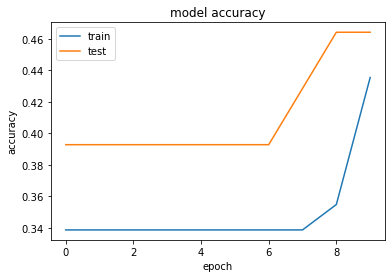

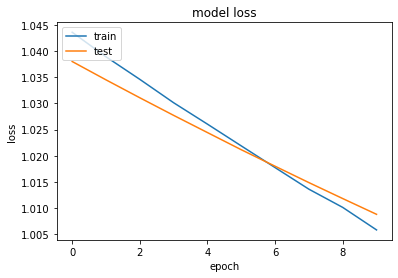

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Evaluate the model

Let's see how the model performs on brand new, unseen before data. Two values will be returned: loss (a number which represents our error, lower values are better), and accuracy.

In [20]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

# make a prediction
testingPredictions = model.predict(x_test)
testingPredictions = list(testingPredictions.argmax(axis=-1))

confidence_scores = model.predict(x_test, batch_size=32)
print(confidence_scores)

target_names = ['Iris-setosa', 'Iris-versicolo', 'Iris-virginica']
print(classification_report(y_test.argmax(axis=-1), testingPredictions, target_names=target_names))

[[0.42762122 0.41295823 0.44243446]
 [0.35250974 0.32392985 0.60524696]
 [0.43586612 0.44269884 0.42642426]
 [0.37471446 0.3844378  0.5459873 ]
 [0.45504722 0.44494137 0.45457846]
 [0.4643153  0.4717982  0.4302415 ]
 [0.40086207 0.36180025 0.44541568]
 [0.37728864 0.3543541  0.42430326]
 [0.35228214 0.3386906  0.5848279 ]
 [0.38459453 0.4043137  0.5558526 ]
 [0.33829817 0.3391232  0.5824827 ]
 [0.33534697 0.3418775  0.5723422 ]
 [0.35706785 0.35122567 0.5822001 ]
 [0.41454646 0.406966   0.43406904]
 [0.43357778 0.4362054  0.41233563]
 [0.3623393  0.35978997 0.57216734]
 [0.37152132 0.38897625 0.54429585]
 [0.4489494  0.43455744 0.46558806]
 [0.425222   0.40765488 0.44766307]
 [0.42546606 0.40155014 0.46251526]
 [0.3989859  0.38752642 0.4166123 ]
 [0.4454113  0.4285052  0.45171425]
 [0.42519718 0.392707   0.45895696]
 [0.459177   0.46658662 0.43680817]
 [0.43081132 0.41612098 0.44845024]
 [0.4287988  0.41869292 0.43770638]
 [0.48990294 0.48567995 0.4777152 ]
 [0.4208343  0.41941833 0.44

In [21]:
results = model.evaluate(x_test, y_test, verbose=1)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

2/2 [==============================] - 0s 2ms/step - loss: 1.0300 - accuracy: 0.3333
loss: 1.030
accuracy: 0.333


Now, we need to export the data in order to support some interactive visualizations that we've created. Feel free to skip over this code block and move to the interactive visualizations below.

In [22]:
# import json
# import os
# import sys

# output_directory = "libraries/"
# output_filename = "predict_LR.json"
# full_path = os.path.join(output_directory, output_filename)

# true_label = []
# for i in range(len(y_test)):
#     for j in range(len(y_test[i])):
#         if y_test[i][j] == 1:
#             if j == 0:
#                 true_label.append(target_names[0])
#             if j == 1:
#                 true_label.append(target_names[1])
#             if j == 2:
#                 true_label.append(target_names[2])


# for i in range(len(testingPredictions)):
#     if testingPredictions[i] == 0:
#         testingPredictions[i] = target_names[0]
#     if testingPredictions[i] == 1:
#         testingPredictions[i] = target_names[1]
#     if testingPredictions[i] == 2:
#         testingPredictions[i] = target_names[2]

# data = []
# data.extend([{
#       'index': i,
#       'true_label': true_label[i],
#       'predicted_label': testingPredictions[i],
#       'confidence_score': confidence_scores.tolist()[i],
#       'features': x_test.tolist()[i]
#   } for i in range(len(testingPredictions))])



# with open(full_path, 'w') as outfile:
#     json.dump(data, outfile, indent=4, sort_keys=False)
    
# collected_epoch_filename = 'predict_LR_extended.json'
# full_path_extended = os.path.join(output_directory, collected_epoch_filename)

# extended_data = {}
# for i, table in enumerate(epoch_history_extracted_data):
#     jsonified = table.to_json(orient='index')
#     parsed = json.loads(jsonified)
# #     extended_data.append(parsed)
#     extended_data[f'{i}'] = parsed
    
# # print(extended_data)
    
# with open(full_path_extended, 'w') as outfile:
#     json.dump(extended_data, outfile, indent=4, sort_keys=False)

In [23]:
import json
import os
import sys

output_directory = "libraries/"
output_filename = "predict_LR_extended.json"
full_path = os.path.join(output_directory, output_filename)

data = {}
for i in range(len(epoch_output[0])):
    data[i] = {}
    data[i]['Num Epochs'] = len(epoch_output)
    data[i]['Index'] = i
    data[i]['Test Label'] = int(epoch_output[0]['actual'][i].argmax())
    data[i]['Test Prediction'] = {}
    data[i]['Test Confidence Score'] = {}
#     data[i]['Intermediate Values'] = {}
    for j in range(len(epoch_output)):
        data[i]['Test Prediction'][j] = int(epoch_output[j]['prediction'][i])
        data[i]['Test Confidence Score'][j] = epoch_output[j]['confidence_score'][i].tolist()
#         data[i]['Intermediate Values'][j] = epoch_output[j]['intermediate_values'][i]
    data[i]['Test Sentence'] = epoch_output[0]['input'][i].tolist()
    
with open(full_path, 'w') as outfile:
    json.dump(data, outfile, indent=4, sort_keys=False)

In [24]:
import os
import sys
output_directory = "libraries/"
collected_epoch_filename = 'predict_LR_extended.json'
full_path_extended = os.path.join(output_directory, collected_epoch_filename)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import libraries.mlvislib as mlvs

In [25]:
cm = mlvs.ConfusionMatrix(full_path_extended)
cm.display()